In [22]:
#@title ##### Classe per il modello *Naive-Bayes KDE*
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# solo per clasificazione di due label
class NaiveBayesKDE:

    conf_matrix_train = None
    conf_matrix_score = None

    # costruttore
    def __init__(self, smooth, verbose=False, plot=False):

        self.kde_0 = []
        self.kde_1 = []
        self.smooth = smooth
        self.verbose = verbose
        self.conf_matrix_train = None
        self.conf_matrix_score = None
        self.plot = plot

    # densità di probabilità, torna KDE(i)(x)
    # dove i è l'indice della feature
    def _pdf(self, kde, x, i) -> str:
        return kde[i](x)[0]

    # discriminante massima verosimiglianza
    def _disc(self, x) -> str:
        p1 = p0 = 1
        for i in range(len(x)):
            p1 *= self._pdf(self.kde_1, x[i], i)
            p0 *= self._pdf(self.kde_0, x[i], i)
        if (p1+p0)>0:
            return p1/(p1+p0)
        else:
            return 0.5

    # classificatore 2 classi
    def _classdisc(self, x) -> str:
        if self._disc(x) >= 0.5:
            return self.classes[1]
        else:
            return self.classes[0]

    # confusion matrix
    def _conf_matrix(self, L1, L0) -> str:
        TP = np.sum((np.array(L1) == self.classes[1]) == True) # True Positive
        TN = np.sum((np.array(L0) == self.classes[0]) == True) # True Negative
        FP = np.sum((np.array(L1) == self.classes[0]) == True) # False Positive
        FN = np.sum((np.array(L0) == self.classes[1]) == True) # False Negative
        return np.array([[TP, FN],[FP, TN]]), TP, TN, FP, FN

    # fit del modello
    def fit(self, features, labels):
        unique, counts = np.unique(labels, return_counts=True)
        if len(unique) != 2:
            raise ValueError("classes must be two values")
        else:
            self.classes = unique

        # converte le features in numpy
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()
        elif not isinstance(features, (np.ndarray, np.generic)):
            features = np.array(features)

        if isinstance(labels, pd.DataFrame):
            labels = features.to_numpy()
        elif not isinstance(labels, (np.ndarray, np.generic)):
            labels = np.array(labels)

        # controlla lo shape dei dati
        if len(features.shape) != 2 or len(labels.shape) != 1:
            raise ValueError(f"data shape is {features.shape} and {labels.shape} but excepted (n, feature_i) and (label_i)")

        mu_0_arr = np.zeros(features.shape[1])
        mu_1_arr = np.zeros(features.shape[1])
        self.kde_0 = []
        self.kde_1 = []

        class_1_indices = np.where( labels == self.classes[1] )
        class_0_indices = np.where( labels == self.classes[0] )
        for column in range(0, features.shape[1]):
            class_1 = features[:, column][class_1_indices]
            class_0 = features[:, column][class_0_indices]

            self.kde_1.append(gaussian_kde(class_1, self.smooth))
            self.kde_0.append(gaussian_kde(class_0, self.smooth))

            if self.verbose:
                mu_1_arr[column]=(class_1.mean())
                mu_0_arr[column]=(class_0.mean())

        if self.verbose:
            print(f"Disc. of mean value class \"{self.classes[0]}\" = {self._disc(mu_0_arr):.6f}")
            print(f"Disc. of mean value class \"{self.classes[1]}\" = {self._disc(mu_1_arr):.6f}")


    # score
    def score(self, features, labels):
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()
        elif not isinstance(features, (np.ndarray, np.generic)):
            raise ValueError(f"unsupported data type")

        sample_1_indices = np.where(labels == self.classes[1])
        sample_0_indices = np.where(labels == self.classes[0])

        sample_1 = np.apply_along_axis(self._classdisc, axis=1, arr=features[sample_1_indices])
        sample_0 = np.apply_along_axis(self._classdisc, axis=1, arr=features[sample_0_indices])

        self.conf_matrix_score, TP, TN, FP, FN = self._conf_matrix(sample_1, sample_0)

        accuracy = (TP+TN)/(TP+TN+FP+FN)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)

        # plot del discriminante delle classi
        if self.plot:
            #plt.figure(figsize=(6,5))
            plt.hist(sample_1, color='red', range=(0,1), label = f"disc. class \"{self.classes[1]}\"")
            plt.hist(sample_0, color='blue', alpha=0.5, range=(0,1), label = f"disc. class \"{self.classes[0]}\"")
            plt.title(f"Class Discriminant\n smooth={self.smooth:.4f}", fontsize = 7)

        return accuracy


[[4.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   2.25]]


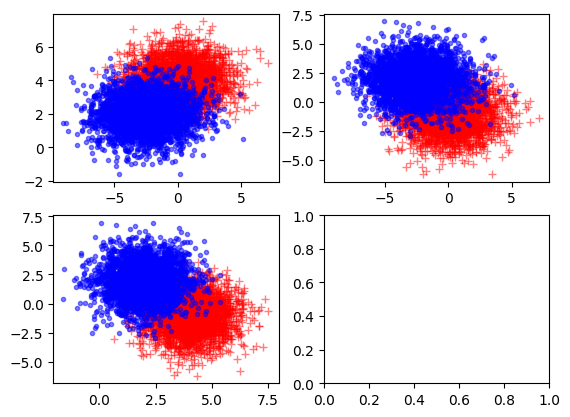

[[-4.96389128  2.48851908 -1.22486244 -1.15986485  2.73036827  0.98007389]
 [-0.64794853  4.80333928 -3.50944238 -4.18736123  2.42718316  3.05766644]
 [-1.87376887  3.03770318 -2.52130029 -4.1311039   0.53254414  1.06369823]
 ...
 [-1.63743641  3.23102828 -1.04625219 -2.49273802  3.07694332  4.37235709]
 [-1.76092183  2.60281425  1.96314476 -2.23048017  2.22460499  1.79740423]
 [ 0.92864581  5.26014446 -0.35842999 -3.25358297  2.1165758   2.37417265]]


In [7]:
#code
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from matplotlib.pyplot import figure as pltfigure
from sklearn.model_selection import train_test_split

N_size = 3000
tr_sample = 2000

mu_s = np.array([0.0, 4.0, -1.0])
mu_b = np.array([-2.5, 2.0, 2.0])
cov = np.diag([4.0,1.0,2.25])

# genera covarianza random sugli elementi diversi dalla diagonale
#cov_rand = [np.random.rand()*8 + 1.0 for i in range(len(cov[cov==0.]))]
#cov[cov == 0.] = cov_rand
print(cov)

signal = np.random.multivariate_normal(mu_s, cov, N_size)
bkg = np.random.multivariate_normal(mu_b, cov, N_size)
labels = [rand.randint(0, 1) for i in range(0, N_size)]
features = np.concatenate((signal, bkg), axis=1)


signal_x0 = np.array([signal[i][0] for i in range(N_size)])
signal_x1 = np.array([signal[i][1] for i in range(N_size)])
signal_x2 = np.array([signal[i][2] for i in range(N_size)])

bkg_x0 = np.array([bkg[i][0] for i in range(N_size)])
bkg_x1 = np.array([bkg[i][1] for i in range(N_size)])
bkg_x2 = np.array([bkg[i][2] for i in range(N_size)])

fig, axs = plt.subplots(2,2)

axs[0,0].plot(signal_x0, signal_x1, 'r+', alpha=0.5)
axs[0,0].plot(bkg_x0, bkg_x1, 'b.', alpha=0.5)
axs[0,1].plot(signal_x0, signal_x2, 'r+', alpha=0.5)
axs[0,1].plot(bkg_x0, bkg_x2, 'b.', alpha=0.5)
axs[1,0].plot(signal_x1, signal_x2, 'r+', alpha=0.5)
axs[1,0].plot(bkg_x1, bkg_x2, 'b.', alpha=0.5)
plt.show()

test_perc = 0.2
train_fts, test_fts, train_lbs, test_lbs = train_test_split(features, labels, shuffle=True, test_size=test_perc, random_state=21)

In [23]:
print('Naive-Bayes Model')
model = NaiveBayesKDE(0.5)# GaussianNB()
model.fit(train_fts, train_lbs)
print(f"train accuracy: {model.score(train_fts, train_lbs):.5f}")
print(f"test accuracy: {model.score(test_fts, test_lbs):.5f}")

Naive-Bayes Model
train accuracy: 0.55583
test accuracy: 0.52000
